# Credit Card Fraud Detection

## Introduction

  It is important that credit card companies are able to recognize frauds on credit card transactions.
  
   On Kaggle, we have access to a dataset which contains transactions made by credit cards in September 2013 by europeans. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.
   
   The features V1, V2, ..., V28 are the principal components obtained with PCA and all are numeric and confidentials.

#### Dataset: 

https://www.kaggle.com/mlg-ulb/creditcardfraud

## Problem Statement

Due to the fraudulent credit card transactions problem and your data, how good we can predict them?

To solve this problem, we'll follow a standard data science pipeline plan of attack:

#### 1. Understand the problem and the data
#### 2. Data exploration
#### 3. Feature engineering / feature selection
#### 4. Model evaluation and selection
#### 5. Model optimization
#### 6. Interpretation of results and predictions

### Getting Start:

Doing the necessary imports:

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import warnings

Let's ignore warnings about deprecated things:

In [51]:
warnings.filterwarnings("ignore")

#### Reading the dataset:

In [52]:
card_transactions = pd.read_csv('creditcard.csv')

## Understand the problem and the data

I will start seeing the shape and columns names of our dataset, to answer my question: How many features and instances do I have?

In [53]:
print(card_transactions.shape)
print('---------------------------------------------------------------------------')
print(card_transactions.columns)

(284807, 31)
---------------------------------------------------------------------------
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


As mentioned before, the features passed by a PCA algorithm and they are confidentials. The name doesn't help us to understand.

Let's check all feature __types__:

In [54]:
print(card_transactions.dtypes)

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object


All of them are numerical and it's coherent. So doesn't need any type of cast.

### Data Distribution

On the Kaggle's challenge description of dataset, they tell this data have a unbalanced distribution. Let's check:

Text(0, 0.5, 'Frequency')

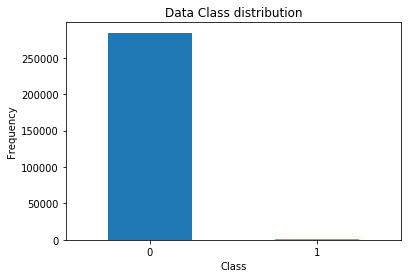

In [55]:
count_classes = pd.value_counts(card_transactions['Class'], sort = True)

# Creating a plot with bar kind:
count_classes.plot(kind = 'bar', rot=0)

# Setting plotting title and axi's legends:
plt.title("Data Class distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")

Now I'm sure, the data is totally unbalanced.

__There are several ways to approach this unbalanced distribution problem:__

- Collect more data. (Not applicable in this case)
***
- Use metrics like F1, Precision, Recall and ROC
    - __Here is a link for a very good post talking about metrics for unbalanced data: https://towardsdatascience.com/what-metrics-should-we-use-on-imbalanced-data-set-precision-recall-roc-e2e79252aeba__
***
- Resampling the dataset

    - This is as method that will process the data to have an approximate 50-50 ratio;
    
    - One way to anchieve this is OVER-sampling, adding copies of the under-represented class (better with __little__ data);
    
    - Another way is UNDER-sampling, deleting instances from the over-represented class (better with __lot's__ of data).
***

## Data exploration / Data cleaning

###  Have any null value in the DataFrame?

I'm going to check if have any value on instances with null values:

In [56]:
print(card_transactions.isnull().values.any())

False


Well, I don't need to worry about treat null values.

### Analysis Fraud and Valid Transactions 

Determine the number of fraud and valid transactions:

In [57]:
fraud_data = card_transactions[card_transactions['Class'] == 1]
normal_data = card_transactions[card_transactions['Class'] == 0]

print('Fraud shape: ' + str(fraud_data.shape))
print('Valid shape: ' + str(normal_data.shape))

Fraud shape: (492, 31)
Valid shape: (284315, 31)


#### How many percents each Class represents on this skewed distribution?

In [58]:
print('No Fraud: ', round(len(fraud_data)/len(card_transactions) * 100,2), '% of the dataset.')
print('Fraud: ', round(len(normal_data)/len(card_transactions) * 100,2), '% of the dataset.')

No Fraud:  0.17 % of the dataset.
Fraud:  99.83 % of the dataset.


#### How different are the amount of money used in different transaction classes?

##### Normal transactions:

In [59]:
print(fraud_data.Amount.describe())

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


##### Fraud transactions:

In [60]:
print(normal_data.Amount.describe())

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


## Feature engineering / feature selection

I am not going to perform feature engineering or feature selection in first instance.

The dataset already has been downgraded in order to contain 30 features (28 anonymous + time + amount). Acording to Kaggle's description, they used PCA as feature engineering to reduce number of features.

The only thing I'm going to do is normalize the _Amount_. As we could see previously, have a lot of variantion on data.

In [61]:
amount_values = card_transactions['Amount'].values
standardized_amount = StandardScaler().fit_transform(amount_values.reshape(-1, 1))
card_transactions['normAmount'] = standardized_amount
card_transactions = card_transactions.drop(['Time', 'Amount'], axis=1)
print(card_transactions['normAmount'].head())

0    0.244964
1   -0.342475
2    1.160686
3    0.140534
4   -0.073403
Name: normAmount, dtype: float64


## Model evaluation and selection

### Approach:
1. Select Classifiers Algorithms to be used.
***
2. Compare what happens when using resampling techniques and when not using it.
    - Evaluate the models by using *_Stratified Cross Validation_ (for not resampled), normal Cross Validation (for resampled) and some of the performance metrics mentioned before.
***
3. Repeat the best resampling/not resampling method, by tuning the parameters.
***

*_Stratified Cross Validation_ is a recommended CV technique to large imbalance in the distribution of the target class which the folds are made by preserving the percentage of samples for each class.

### Classifier Algorithms:

I'm going to use these algorithms:

* [Multi-layer Perceptron (MLPClassifier)](http://scikit-learn.org/stable/modules/neural_networks_supervised.html#multi-layer-perceptron)
* [Random Forest Classifier (RandomForestClassifier)](http://scikit-learn.org/stable/modules/ensemble.html#random-forests)

### Not resampling:

Spliting data in X set and Y set (target): 

In [62]:
X = card_transactions.iloc[:, card_transactions.columns != 'Class']
y = card_transactions.iloc[:, card_transactions.columns == 'Class']

I'm going to create a function to perform and evaluate the models.
- As said before, going to use Stratified Cross Validation because the dataset distribution is imbalanced
- Will evaluate models with metrics: F1 and ROC_AUC

In [63]:
# This fuction will evaluate used models returning f1 and roc_auc scores averages 
# of Stratified Cross Validation folders.
def evaluate_models(X, y):
    # Creating dict to save scores to evaluate:
    f1_scores['MLPClassifier'] = []
    roc_scores['MLPClassifier'] = []
    f1_scores['RandomForestClassifier'] = []
    roc_scores['RandomForestClassifier'] = []

    # Initializing Stratified Cross Validation:
    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
    count = 0
    for train_index, test_index in sss.split(X, y):
        count += 1
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        perform_models(
            [
                MLPClassifier(solver='lbfgs'),
                RandomForestClassifier(n_estimators=100, n_jobs=-1),
            ],
            X_train, X_test,
            y_train, y_test,
            count
        )
    print('Results:')
    for model in f1_scores.keys():
        print('  ' + model + ' has f1 average: ' + str( sum(f1_scores[model]) / len(f1_scores[model]) ))
        print('  ' + model + ' has roc_auc average: ' + str( sum(roc_scores[model]) / len(roc_scores[model]) ))

# Function to perform a list of models:
def perform_models(classifiers, X_train, X_test, y_train, y_test, count):
    string = ''
    print(str(count) + ' interaction:\n')
    for classifier in classifiers:
        # Creating key index in dict to save evaluation metrics value:

        string += classifier.__class__.__name__

        # Train:
        classifier.fit(X_train, y_train)
        
        # Predicting values with model:
        predicteds = classifier.predict(X_test)
        
        # Getting score metrics:
        f1 = f1_score(y_test, predicteds)
        roc = roc_auc_score(y_test, predicteds, average='weighted')
        
        # Adding scores:
        f1_scores[classifier.__class__.__name__].append(f1)
        roc_scores[classifier.__class__.__name__].append(roc)

        string += ' has f1: ' + str(f1) + ' roc_auc: ' + str(roc)+ '\n'
        print('    ' + string)
        string = ''
    print('-----------------------------------------------------------------')

Now I'm going to create f1_scores and roc_scores dictionaries and call evaluate_models function:

In [64]:
f1_scores = {}
roc_scores = {}

evaluate_models(X, y)

1 interaction:

    MLPClassifier has f1: 0.8057553956834532 roc_auc: 0.8782728622285454

    RandomForestClassifier has f1: 0.849624060150376 roc_auc: 0.8817274467151365

----------------------------------------------
2 interaction:

    MLPClassifier has f1: 0.8461538461538461 roc_auc: 0.9086841296422749

    RandomForestClassifier has f1: 0.8654545454545455 roc_auc: 0.9019801309604346

----------------------------------------------
3 interaction:

    MLPClassifier has f1: 0.8175182481751826 roc_auc: 0.8782963102618417

    RandomForestClassifier has f1: 0.8602941176470589 roc_auc: 0.8952292362120018

----------------------------------------------
4 interaction:

    MLPClassifier has f1: 0.8382352941176471 roc_auc: 0.8850765150518946

    RandomForestClassifier has f1: 0.8602941176470589 roc_auc: 0.8952292362120018

----------------------------------------------
5 interaction:

    MLPClassifier has f1: 0.8059701492537312 roc_auc: 0.8647945207649763

    RandomForestClassifier has 

### Resampling (with under-sampling):

## Model optimization

## Interpretation of results and predictions